In [432]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [433]:
# import scoring and utility functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, \
    learning_curve, ShuffleSplit, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [434]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

In [435]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [436]:
# read the raw data
data = pd.read_csv("Coding Challenge Data.csv")

# rename col names for easier handling
new_col_names = []
for name in data.columns:
    n_temp = "_".join(name.lower().replace("(%)", "per").split(" ")[0:2])
    new_col_names.append(n_temp)
data.columns = new_col_names

# drop the redundant sample id column
data.drop(["sample_id"], axis=1, inplace=True)

##
per_cols = [col for col in data.columns if "per" in col]
other_cols = ['grain_size','seam_type', 'nde_yield', 'tensile_yield']
data = data [per_cols + other_cols]
data.head()

,c_per,mn_per,cr_per,cu_per,al_per,mo_per,ni_per,si_per,v_per,grain_size,seam_type,nde_yield,tensile_yield
0,0.20,1.01,0.10,0.07,0.01,0.03,0.05,0.16,0.01,5.33,SMLS,66.0,62.0
1,0.12,0.85,0.03,0.02,0.04,0.01,0.03,0.13,0.01,7.06,ERW,67.0,64.5
2,0.18,1.20,0.09,0.07,0.02,0.02,0.04,0.26,0.01,6.56,SMLS,53.5,55.8
3,0.19,0.72,0.09,0.15,0.04,0.02,0.08,0.01,0.05,4.89,ERW,75.9,76.4
4,0.15,0.76,0.05,0.11,0.01,0.02,0.08,0.01,0.01,14.12,ERW,57.5,51.2


In [437]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   c_per          50 non-null     float64
 1   mn_per         50 non-null     float64
 2   cr_per         50 non-null     float64
 3   cu_per         50 non-null     float64
 4   al_per         50 non-null     float64
 5   mo_per         50 non-null     float64
 6   ni_per         50 non-null     float64
 7   si_per         50 non-null     float64
 8   v_per          50 non-null     float64
 9   grain_size     50 non-null     float64
 10  seam_type      50 non-null     object 
 11  nde_yield      50 non-null     float64
 12  tensile_yield  50 non-null     float64
dtypes: float64(12), object(1)
memory usage: 5.2+ KB


In [438]:
data.describe()

,c_per,mn_per,cr_per,cu_per,al_per,mo_per,ni_per,si_per,v_per,grain_size,nde_yield,tensile_yield
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,0.204800,0.890400,0.053000,0.102200,0.021600,0.017000,0.07180,0.040200,0.01100,10.314800,60.356000,55.004000
std,0.060651,0.363705,0.167591,0.169493,0.016333,0.022968,0.19403,0.067928,0.01233,5.141806,11.325106,10.948338
min,0.080000,0.380000,0.000000,0.010000,0.010000,0.010000,0.01000,0.000000,0.00000,4.260000,34.100000,24.800000
25%,0.172500,0.735000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.01000,7.022500,53.050000,49.275000
50%,0.210000,0.820000,0.025000,0.035000,0.010000,0.010000,0.02000,0.010000,0.01000,9.885000,58.250000,54.900000
75%,0.240000,1.017500,0.040000,0.080000,0.030000,0.010000,0.05000,0.020000,0.01000,12.010000,66.150000,62.000000
max,0.350000,2.850000,1.200000,0.740000,0.060000,0.130000,1.03000,0.260000,0.05000,38.110000,94.900000,80.500000


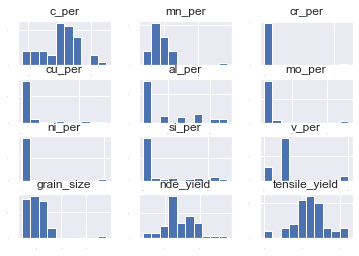

In [439]:
# observe numeric column distributions
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

In [440]:
# isolate target, numerical and categorical columns
target_col = ['tensile_yield']
numerical_cols = [col for col in data.columns if data[col].dtype=='float64' and col not in target_col]
categorical_cols = [col for col in data.columns if col not in numerical_cols and col not in target_col]

In [441]:
# 6. let us use a log transformation to transform the skewed features to as close as normal distributions
data_transformed = data.copy()
cols_to_transform = numerical_cols

for col in cols_to_transform:
    data_transformed[col] = data_transformed[col].apply(lambda x: np.log(x + 0.00000000001))

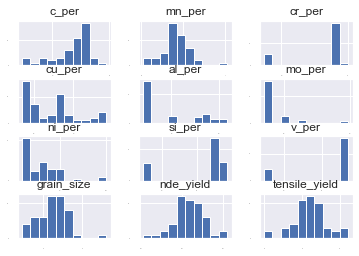

In [442]:
# observe numeric column distributions
data_transformed.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

In [443]:

# we will end up with 8 features
X = data_transformed.drop(target_col, axis=1)
Y = data_transformed[target_col].values.ravel()

In [444]:
# create a transformer pipeline to do proper transformation to the columns
ohe = OneHotEncoder() # one hot encodes categorical columns
scaler = StandardScaler() # standardizes numerical columns for more uniform feature scaling across columns

ct = make_column_transformer(
    (ohe, categorical_cols),
    (scaler, numerical_cols),
    remainder='passthrough'
)

# do the transformation of columns
X = ct.fit_transform(X)

In [447]:
# split the dataset into train and validation sets. here we follow a 70-30% split
validation_size = 0.25 
seed = 42 
# now do the split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Evaluate an array on algorithms to decide on baseline performance
#num_folds = int(X.shape[0] * (1 - validation_size))
num_folds = 3
scoring = 'neg_root_mean_squared_error'
#scoring = 'neg_mean_absolute_error'


# Spot-Check Algorithms 
models = [] 
models.append(('LR' ,LinearRegression())) 
models.append(('LASSO',Lasso())) 
models.append(('EN',ElasticNet())) 
models.append(('KNN',KNeighborsRegressor())) 
models.append(('DT',DecisionTreeRegressor()))
models.append(('SVR',SVR()))
models.append(('RF',RandomForestRegressor()))
models.append(('GB',ExtraTreesRegressor()))
models.append(('ET',GradientBoostingRegressor()))
models.append(('AB',AdaBoostRegressor()))
models.append(('XGB',xgb.XGBRegressor()))

In [448]:
results = [] 
names = [] 

for name, model in models: 
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results) 
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -9.991247 (0.739496)
LASSO: -8.117497 (2.799768)
EN: -7.984632 (3.068178)
KNN: -8.596623 (2.648311)
DT: -10.411038 (2.064146)
SVR: -10.898639 (2.625704)
RF: -7.159255 (2.775504)
GB: -7.670521 (3.376133)
ET: -8.956170 (3.142447)
AB: -8.410161 (4.570489)
XGB: -10.281588 (2.457336)


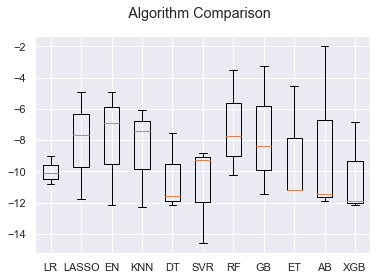

In [449]:
# Compare Algorithms 
fig = plt.figure() 
fig.suptitle(' Algorithm Comparison' ) 
ax = fig.add_subplot(111) 
plt.boxplot(results) 

ax.set_xticklabels(names);

In [ ]:
param_grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], "l1_ratio": np.arange(0.0, 1.0, 0.1)}
model = ElasticNet(max_iter=10_0000) 
#"l1_ratio": np.arange(0.0, 1.0, 0.1)
#model = Lasso(max_iter=10_000)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold) 
grid_result = grid.fit(X_train, Y_train)
best_model = grid.best_estimator_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
len(Y_validation)

In [ ]:
predictions = best_model.predict(X_validation)

In [ ]:
sns.scatterplot(y=predictions, x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Preidcted Values")

In [ ]:
np.sqrt(mean_squared_error(predictions, Y_validation))

In [ ]:
X_train.shape[1]

In [ ]:
# create the ANN model - cell type
model = Sequential()
model.add(Dense(units=16, input_shape=(X_train.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=4))
# model.add(Activation("relu"))
# model.add(Dense(units=2))
# model.add(Activation("relu"))
model.add(Dense(units=1))
model.summary()

In [ ]:
# init some global variables
epochs = 700
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

H = model.fit(X_train, Y_train,
              validation_data=(X_validation, Y_validation),
              verbose=1,
              epochs=epochs)

In [ ]:
keras_preds = model.predict(X_validation)

In [ ]:
sns.scatterplot(y=keras_preds.ravel(), x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Preidcted Values")

Best: -7.950633 using {'alpha': 1, 'l1_ratio': 0.7000000000000001}


In [451]:
len(Y_validation)

13

In [452]:
predictions = best_model.predict(X_validation)

Text(0, 0.5, 'Preidcted Values')

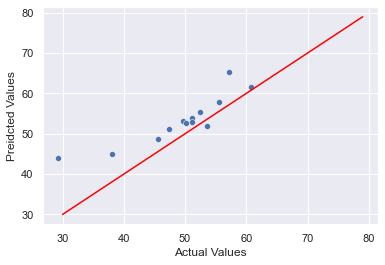

In [453]:
sns.scatterplot(y=predictions, x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Preidcted Values")

In [454]:
np.sqrt(mean_squared_error(predictions, Y_validation))

5.577099787915095

In [455]:
X_train.shape[1]

14

In [465]:
# create the ANN model - cell type
model = Sequential()
model.add(Dense(units=16, input_shape=(X_train.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=4))
# model.add(Activation("relu"))
# model.add(Dense(units=2))
# model.add(Activation("relu"))
model.add(Dense(units=1))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 16)                240       
_________________________________________________________________
activation_33 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [466]:
# init some global variables
epochs = 700
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

H = model.fit(X_train, Y_train,
              validation_data=(X_validation, Y_validation),
              verbose=1,
              epochs=epochs)

Train on 37 samples, validate on 13 samples
Epoch 1/700
37/37 [==============================] - 1s 15ms/sample - loss: 3316.4578 - mean_squared_error: 3316.4578 - val_loss: 2455.6228 - val_mean_squared_error: 2455.6228
Epoch 2/700
37/37 [==============================] - 0s 835us/sample - loss: 3313.4088 - mean_squared_error: 3313.4087 - val_loss: 2453.2661 - val_mean_squared_error: 2453.2661
Epoch 3/700
37/37 [==============================] - 0s 971us/sample - loss: 3310.6889 - mean_squared_error: 3310.6887 - val_loss: 2450.9287 - val_mean_squared_error: 2450.9287
Epoch 4/700
37/37 [==============================] - 0s 970us/sample - loss: 3307.9062 - mean_squared_error: 3307.9062 - val_loss: 2448.6243 - val_mean_squared_error: 2448.6243
Epoch 5/700
37/37 [==============================] - 0s 943us/sample - loss: 3305.0877 - mean_squared_error: 3305.0879 - val_loss: 2446.3345 - val_mean_squared_error: 2446.3345
Epoch 6/700
37/37 [==============================] - 0s 809us/sample - l

Epoch 47/700
37/37 [==============================] - 0s 809us/sample - loss: 3177.6887 - mean_squared_error: 3177.6887 - val_loss: 2341.9998 - val_mean_squared_error: 2341.9998
Epoch 48/700
37/37 [==============================] - 0s 674us/sample - loss: 3174.2832 - mean_squared_error: 3174.2832 - val_loss: 2339.3511 - val_mean_squared_error: 2339.3511
Epoch 49/700
37/37 [==============================] - 0s 700us/sample - loss: 3170.7754 - mean_squared_error: 3170.7754 - val_loss: 2336.6675 - val_mean_squared_error: 2336.6675
Epoch 50/700
37/37 [==============================] - 0s 674us/sample - loss: 3167.1690 - mean_squared_error: 3167.1689 - val_loss: 2334.0024 - val_mean_squared_error: 2334.0024
Epoch 51/700
37/37 [==============================] - 0s 647us/sample - loss: 3163.5688 - mean_squared_error: 3163.5688 - val_loss: 2331.2373 - val_mean_squared_error: 2331.2373
Epoch 52/700
37/37 [==============================] - 0s 701us/sample - loss: 3159.8770 - mean_squared_error: 

37/37 [==============================] - 0s 728us/sample - loss: 2969.7016 - mean_squared_error: 2969.7017 - val_loss: 2192.1604 - val_mean_squared_error: 2192.1604
Epoch 94/700
37/37 [==============================] - 0s 916us/sample - loss: 2963.9875 - mean_squared_error: 2963.9875 - val_loss: 2188.0610 - val_mean_squared_error: 2188.0610
Epoch 95/700
37/37 [==============================] - 0s 808us/sample - loss: 2957.8482 - mean_squared_error: 2957.8481 - val_loss: 2183.9893 - val_mean_squared_error: 2183.9893
Epoch 96/700
37/37 [==============================] - 0s 863us/sample - loss: 2952.1018 - mean_squared_error: 2952.1018 - val_loss: 2179.8865 - val_mean_squared_error: 2179.8865
Epoch 97/700
37/37 [==============================] - 0s 808us/sample - loss: 2946.0170 - mean_squared_error: 2946.0171 - val_loss: 2175.6753 - val_mean_squared_error: 2175.6753
Epoch 98/700
37/37 [==============================] - 0s 863us/sample - loss: 2940.0668 - mean_squared_error: 2940.0669 - v

Epoch 139/700
37/37 [==============================] - 0s 715us/sample - loss: 2636.3242 - mean_squared_error: 2636.3242 - val_loss: 1970.1082 - val_mean_squared_error: 1970.1082
Epoch 140/700
37/37 [==============================] - 0s 674us/sample - loss: 2627.6754 - mean_squared_error: 2627.6755 - val_loss: 1964.4076 - val_mean_squared_error: 1964.4076
Epoch 141/700
37/37 [==============================] - 0s 701us/sample - loss: 2618.8050 - mean_squared_error: 2618.8049 - val_loss: 1958.6310 - val_mean_squared_error: 1958.6310
Epoch 142/700
37/37 [==============================] - 0s 728us/sample - loss: 2610.1389 - mean_squared_error: 2610.1389 - val_loss: 1952.8307 - val_mean_squared_error: 1952.8307
Epoch 143/700
37/37 [==============================] - 0s 755us/sample - loss: 2601.2781 - mean_squared_error: 2601.2781 - val_loss: 1947.0706 - val_mean_squared_error: 1947.0706
Epoch 144/700
37/37 [==============================] - 0s 701us/sample - loss: 2592.2491 - mean_squared_e

Epoch 185/700
37/37 [==============================] - 0s 808us/sample - loss: 2171.6458 - mean_squared_error: 2171.6460 - val_loss: 1677.2350 - val_mean_squared_error: 1677.2350
Epoch 186/700
37/37 [==============================] - 0s 674us/sample - loss: 2160.5058 - mean_squared_error: 2160.5056 - val_loss: 1670.3035 - val_mean_squared_error: 1670.3035
Epoch 187/700
37/37 [==============================] - 0s 863us/sample - loss: 2149.1849 - mean_squared_error: 2149.1851 - val_loss: 1663.4165 - val_mean_squared_error: 1663.4165
Epoch 188/700
37/37 [==============================] - 0s 863us/sample - loss: 2138.0346 - mean_squared_error: 2138.0347 - val_loss: 1656.5951 - val_mean_squared_error: 1656.5951
Epoch 189/700
37/37 [==============================] - 0s 862us/sample - loss: 2126.9992 - mean_squared_error: 2126.9993 - val_loss: 1649.8693 - val_mean_squared_error: 1649.8693
Epoch 190/700
37/37 [==============================] - 0s 755us/sample - loss: 2115.3400 - mean_squared_e

Epoch 231/700
37/37 [==============================] - 0s 674us/sample - loss: 1643.1380 - mean_squared_error: 1643.1381 - val_loss: 1353.9877 - val_mean_squared_error: 1353.9877
Epoch 232/700
37/37 [==============================] - 0s 702us/sample - loss: 1632.3389 - mean_squared_error: 1632.3389 - val_loss: 1346.7916 - val_mean_squared_error: 1346.7916
Epoch 233/700
37/37 [==============================] - 0s 728us/sample - loss: 1621.2539 - mean_squared_error: 1621.2538 - val_loss: 1339.4937 - val_mean_squared_error: 1339.4937
Epoch 234/700
37/37 [==============================] - 0s 593us/sample - loss: 1610.1239 - mean_squared_error: 1610.1239 - val_loss: 1332.2169 - val_mean_squared_error: 1332.2169
Epoch 235/700
37/37 [==============================] - 0s 808us/sample - loss: 1599.3197 - mean_squared_error: 1599.3197 - val_loss: 1324.9877 - val_mean_squared_error: 1324.9877
Epoch 236/700
37/37 [==============================] - 0s 825us/sample - loss: 1588.2595 - mean_squared_e

Epoch 277/700
37/37 [==============================] - 0s 734us/sample - loss: 1165.4764 - mean_squared_error: 1165.4763 - val_loss: 1043.2207 - val_mean_squared_error: 1043.2207
Epoch 278/700
37/37 [==============================] - 0s 809us/sample - loss: 1156.0333 - mean_squared_error: 1156.0333 - val_loss: 1036.8253 - val_mean_squared_error: 1036.8253
Epoch 279/700
37/37 [==============================] - 0s 782us/sample - loss: 1146.4639 - mean_squared_error: 1146.4639 - val_loss: 1030.2880 - val_mean_squared_error: 1030.2880
Epoch 280/700
37/37 [==============================] - 0s 619us/sample - loss: 1136.9214 - mean_squared_error: 1136.9215 - val_loss: 1023.6155 - val_mean_squared_error: 1023.6155
Epoch 281/700
37/37 [==============================] - 0s 782us/sample - loss: 1127.6167 - mean_squared_error: 1127.6167 - val_loss: 1016.9026 - val_mean_squared_error: 1016.9026
Epoch 282/700
37/37 [==============================] - 0s 701us/sample - loss: 1118.0532 - mean_squared_e

37/37 [==============================] - 0s 755us/sample - loss: 779.6895 - mean_squared_error: 779.6895 - val_loss: 768.1534 - val_mean_squared_error: 768.1534
Epoch 324/700
37/37 [==============================] - 0s 823us/sample - loss: 772.6536 - mean_squared_error: 772.6536 - val_loss: 762.7432 - val_mean_squared_error: 762.7432
Epoch 325/700
37/37 [==============================] - 0s 701us/sample - loss: 765.2955 - mean_squared_error: 765.2955 - val_loss: 757.4058 - val_mean_squared_error: 757.4058
Epoch 326/700
37/37 [==============================] - 0s 836us/sample - loss: 758.3753 - mean_squared_error: 758.3752 - val_loss: 751.9892 - val_mean_squared_error: 751.9892
Epoch 327/700
37/37 [==============================] - 0s 916us/sample - loss: 751.2678 - mean_squared_error: 751.2678 - val_loss: 746.4113 - val_mean_squared_error: 746.4113
Epoch 328/700
37/37 [==============================] - 0s 916us/sample - loss: 744.4125 - mean_squared_error: 744.4125 - val_loss: 740.7923

Epoch 370/700
37/37 [==============================] - 0s 701us/sample - loss: 500.6529 - mean_squared_error: 500.6529 - val_loss: 542.4462 - val_mean_squared_error: 542.4462
Epoch 371/700
37/37 [==============================] - 0s 728us/sample - loss: 495.8633 - mean_squared_error: 495.8633 - val_loss: 538.0855 - val_mean_squared_error: 538.0855
Epoch 372/700
37/37 [==============================] - 0s 593us/sample - loss: 491.2015 - mean_squared_error: 491.2015 - val_loss: 533.7107 - val_mean_squared_error: 533.7107
Epoch 373/700
37/37 [==============================] - 0s 647us/sample - loss: 486.4923 - mean_squared_error: 486.4923 - val_loss: 529.4169 - val_mean_squared_error: 529.4169
Epoch 374/700
37/37 [==============================] - 0s 701us/sample - loss: 481.7950 - mean_squared_error: 481.7950 - val_loss: 525.2556 - val_mean_squared_error: 525.2556
Epoch 375/700
37/37 [==============================] - 0s 674us/sample - loss: 477.1328 - mean_squared_error: 477.1329 - val_

Epoch 417/700
37/37 [==============================] - 0s 863us/sample - loss: 319.6779 - mean_squared_error: 319.6779 - val_loss: 370.7766 - val_mean_squared_error: 370.7766
Epoch 418/700
37/37 [==============================] - 0s 756us/sample - loss: 316.6019 - mean_squared_error: 316.6019 - val_loss: 367.6325 - val_mean_squared_error: 367.6325
Epoch 419/700
37/37 [==============================] - 0s 674us/sample - loss: 313.7092 - mean_squared_error: 313.7092 - val_loss: 364.3676 - val_mean_squared_error: 364.3676
Epoch 420/700
37/37 [==============================] - 0s 850us/sample - loss: 310.6179 - mean_squared_error: 310.6179 - val_loss: 361.1316 - val_mean_squared_error: 361.1316
Epoch 421/700
37/37 [==============================] - 0s 782us/sample - loss: 307.6063 - mean_squared_error: 307.6063 - val_loss: 357.9348 - val_mean_squared_error: 357.9348
Epoch 422/700
37/37 [==============================] - 0s 824us/sample - loss: 304.5429 - mean_squared_error: 304.5429 - val_

Epoch 464/700
37/37 [==============================] - 0s 707us/sample - loss: 199.8672 - mean_squared_error: 199.8672 - val_loss: 235.5767 - val_mean_squared_error: 235.5767
Epoch 465/700
37/37 [==============================] - 0s 701us/sample - loss: 197.8998 - mean_squared_error: 197.8998 - val_loss: 233.2399 - val_mean_squared_error: 233.2399
Epoch 466/700
37/37 [==============================] - 0s 620us/sample - loss: 196.0144 - mean_squared_error: 196.0144 - val_loss: 230.9233 - val_mean_squared_error: 230.9233
Epoch 467/700
37/37 [==============================] - 0s 674us/sample - loss: 194.1096 - mean_squared_error: 194.1096 - val_loss: 228.5695 - val_mean_squared_error: 228.5695
Epoch 468/700
37/37 [==============================] - 0s 674us/sample - loss: 192.3748 - mean_squared_error: 192.3748 - val_loss: 226.2539 - val_mean_squared_error: 226.2539
Epoch 469/700
37/37 [==============================] - 0s 647us/sample - loss: 190.5069 - mean_squared_error: 190.5069 - val_

Epoch 511/700
37/37 [==============================] - 0s 647us/sample - loss: 127.0730 - mean_squared_error: 127.0730 - val_loss: 142.9311 - val_mean_squared_error: 142.9311
Epoch 512/700
37/37 [==============================] - 0s 755us/sample - loss: 125.9217 - mean_squared_error: 125.9217 - val_loss: 141.3275 - val_mean_squared_error: 141.3275
Epoch 513/700
37/37 [==============================] - 0s 728us/sample - loss: 124.7682 - mean_squared_error: 124.7682 - val_loss: 139.8228 - val_mean_squared_error: 139.8228
Epoch 514/700
37/37 [==============================] - 0s 728us/sample - loss: 123.5910 - mean_squared_error: 123.5910 - val_loss: 138.3637 - val_mean_squared_error: 138.3637
Epoch 515/700
37/37 [==============================] - 0s 796us/sample - loss: 122.5200 - mean_squared_error: 122.5200 - val_loss: 136.9260 - val_mean_squared_error: 136.9260
Epoch 516/700
37/37 [==============================] - 0s 728us/sample - loss: 121.4840 - mean_squared_error: 121.4840 - val_

37/37 [==============================] - 0s 863us/sample - loss: 85.4337 - mean_squared_error: 85.4337 - val_loss: 85.9722 - val_mean_squared_error: 85.9722
Epoch 559/700
37/37 [==============================] - 0s 890us/sample - loss: 84.7287 - mean_squared_error: 84.7287 - val_loss: 84.8829 - val_mean_squared_error: 84.8829
Epoch 560/700
37/37 [==============================] - 0s 628us/sample - loss: 83.9697 - mean_squared_error: 83.9697 - val_loss: 83.8484 - val_mean_squared_error: 83.8484
Epoch 561/700
37/37 [==============================] - 0s 620us/sample - loss: 83.2945 - mean_squared_error: 83.2945 - val_loss: 82.7985 - val_mean_squared_error: 82.7985
Epoch 562/700
37/37 [==============================] - 0s 728us/sample - loss: 82.6462 - mean_squared_error: 82.6462 - val_loss: 81.7434 - val_mean_squared_error: 81.7434
Epoch 563/700
37/37 [==============================] - 0s 647us/sample - loss: 81.9958 - mean_squared_error: 81.9958 - val_loss: 80.7163 - val_mean_squared_err

37/37 [==============================] - 0s 781us/sample - loss: 61.9166 - mean_squared_error: 61.9166 - val_loss: 52.7941 - val_mean_squared_error: 52.7941
Epoch 607/700
37/37 [==============================] - 0s 890us/sample - loss: 61.5579 - mean_squared_error: 61.5579 - val_loss: 52.3754 - val_mean_squared_error: 52.3754
Epoch 608/700
37/37 [==============================] - 0s 728us/sample - loss: 61.2484 - mean_squared_error: 61.2484 - val_loss: 51.9540 - val_mean_squared_error: 51.9540
Epoch 609/700
37/37 [==============================] - 0s 593us/sample - loss: 60.9059 - mean_squared_error: 60.9059 - val_loss: 51.5489 - val_mean_squared_error: 51.5489
Epoch 610/700
37/37 [==============================] - 0s 673us/sample - loss: 60.5900 - mean_squared_error: 60.5900 - val_loss: 51.1707 - val_mean_squared_error: 51.1707
Epoch 611/700
37/37 [==============================] - 0s 755us/sample - loss: 60.2782 - mean_squared_error: 60.2781 - val_loss: 50.7988 - val_mean_squared_err

Epoch 654/700
37/37 [==============================] - 0s 700us/sample - loss: 48.9713 - mean_squared_error: 48.9713 - val_loss: 37.0810 - val_mean_squared_error: 37.0810
Epoch 655/700
37/37 [==============================] - 0s 837us/sample - loss: 48.8061 - mean_squared_error: 48.8061 - val_loss: 36.9316 - val_mean_squared_error: 36.9316
Epoch 656/700
37/37 [==============================] - 0s 755us/sample - loss: 48.6116 - mean_squared_error: 48.6116 - val_loss: 36.7696 - val_mean_squared_error: 36.7696
Epoch 657/700
37/37 [==============================] - 0s 674us/sample - loss: 48.4652 - mean_squared_error: 48.4652 - val_loss: 36.5801 - val_mean_squared_error: 36.5801
Epoch 658/700
37/37 [==============================] - ETA: 0s - loss: 48.9908 - mean_squared_error: 48.99 - 0s 809us/sample - loss: 48.2777 - mean_squared_error: 48.2777 - val_loss: 36.3884 - val_mean_squared_error: 36.3884
Epoch 659/700
37/37 [==============================] - 0s 674us/sample - loss: 48.1040 - me

In [467]:
keras_preds = model.predict(X_validation)

Text(0, 0.5, 'Preidcted Values')

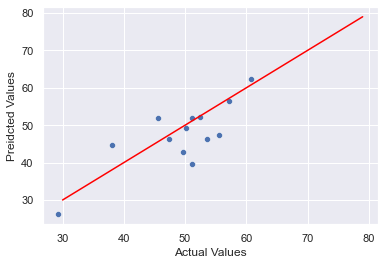

In [468]:
sns.scatterplot(y=keras_preds.ravel(), x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Preidcted Values")